# Evaluating bias of ML against CERRA data for Precipitation

Training Period: 1985 to 2015
Prediction period: 2016 to 2020

In [1]:
PREDICTAND = 'pr'

## Imports

In [2]:
# builtins
import datetime
import warnings
import calendar

# externals
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score

In [3]:
# mapping from predictands to variable names
NAMES = {'pr': 'precipitation'}

# dataset names mapping
PRED = 'LGBM SEAS5 $P_{\mathrm{mean \ daily}}$'
TRUE = 'CERRA $P_{\mathrm{mean \ daily}}$'

In [4]:
y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/sf_downscaling/RESULTS/pr/LGBMRegressor_pr_ztuvq_500_850_mslppr_0mm_dem_doy_hindcast.nc")
y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/pr/CERRA_total_precipitation_1985_2020.nc")

In [5]:
# subset to time period covered by predictions
y_true = y_true.sel(time=y_pred.time)

def get_time_range(dataset):
    time_coord = dataset.time

    # Get the starting and ending years
    start_year = time_coord.min().dt.year.item()
    end_year = time_coord.max().dt.year.item()

    return str(start_year), str(end_year)

start_year, end_year = get_time_range(y_pred)
print("Starting year:", start_year)
print("Ending year:", end_year)


Starting year: 2016
Ending year: 2017


In [6]:
y_pred = y_pred.rename({'pr': 'precipitation'})
y_pred

<xarray.Dataset> Size: 1GB
Dimensions:        (time: 366, number: 25, y: 96, x: 161)
Coordinates:
  * time           (time) datetime64[ns] 3kB 2016-02-01 ... 2017-01-31
  * number         (number) int64 200B 0 1 2 3 4 5 6 7 ... 18 19 20 21 22 23 24
  * y              (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.86 49.93 50.0
  * x              (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.69 15.76 15.82
Data variables:
    precipitation  (time, y, x, number) float64 1GB ...

In [7]:
# Minor changes to be made to dataset to align and making it compliant
# y_true = y_true.drop_vars("spatial_ref")
y_true = y_true.rename({'tp': 'precipitation'})
#y_pred = y_pred.rename({'pr': 'precipitation'})
y_true = y_true.rename({'lon': 'x','lat': 'y'})
y_true


<xarray.Dataset> Size: 23MB
Dimensions:        (x: 161, y: 96, time: 366)
Coordinates:
  * x              (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.69 15.76 15.82
  * y              (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.86 49.93 50.0
  * time           (time) datetime64[ns] 3kB 2016-02-01 ... 2017-01-31
Data variables:
    precipitation  (time, y, x) float32 23MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             French Weather Service - Toulouse
    GRIB_centre:             lfpw
    GRIB_centreDescription:  French Weather Service - Toulouse
    history:                 Fri Dec 08 07:08:04 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [8]:
y_true

<xarray.Dataset> Size: 23MB
Dimensions:        (x: 161, y: 96, time: 366)
Coordinates:
  * x              (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.69 15.76 15.82
  * y              (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.86 49.93 50.0
  * time           (time) datetime64[ns] 3kB 2016-02-01 ... 2017-01-31
Data variables:
    precipitation  (time, y, x) float32 23MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             French Weather Service - Toulouse
    GRIB_centre:             lfpw
    GRIB_centreDescription:  French Weather Service - Toulouse
    history:                 Fri Dec 08 07:08:04 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [9]:
y_pred = y_pred["precipitation"].median(dim='number')
y_pred = y_pred.to_dataset(name="precipitation")

y_pred

<xarray.Dataset> Size: 45MB
Dimensions:        (time: 366, y: 96, x: 161)
Coordinates:
  * time           (time) datetime64[ns] 3kB 2016-02-01 ... 2017-01-31
  * y              (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.86 49.93 50.0
  * x              (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.69 15.76 15.82
Data variables:
    precipitation  (time, y, x) float64 45MB 0.03138 0.03798 ... 3.902 3.752

In [10]:
# aligndata_varsasets
if len(y_pred.data_vars) > 1:
    y_true, y_pred_pr = xr.align(y_true.precipitation, y_pred.precipitation, join='override')
else:
    y_true, y_pred_pr = xr.align(y_true.precipitation, y_pred.precipitation, join='override')

In [11]:
# mask missing values
mask = ~np.isnan(y_true)
y_pred_pr = y_pred_pr.where(mask, other=np.nan)    
if len(y_pred.data_vars) > 1:
    y_pred_prob = y_pred_prob.where(mask, other=np.nan)

In [12]:
# calculate monthly precipitation (mm / month)
y_pred_m = y_pred_pr.resample(time='1M').sum(skipna=False)
y_true_m = y_true.resample(time='1M').sum(skipna=False)

/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


In [13]:
# calculate mean annual cycle
y_pred_ac = y_pred_m.groupby('time.month').mean(dim=('y', 'x', 'time'), skipna=True).values.squeeze()
y_true_ac = y_true_m.groupby('time.month').mean(dim=('y', 'x', 'time'), skipna=True).values.squeeze()

In [14]:
def anomalies(ds, timescale='time.dayofyear', standard=False):
        # group dataset by time scale
        groups = ds.groupby(timescale).groups

        # compute anomalies over time
        anomalies = {}
        for time, time_scale in groups.items():
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=RuntimeWarning)
                # anomaly = (x(t) - mean(x, t))
                anomalies[time] = (ds.isel(time=time_scale) -
                                   ds.isel(time=time_scale).mean(dim='time'))

                # standardized anomaly = (x(t) - mean(x, t)) / std(x, t)
                if standard:
                    anomalies[time] /= ds.isel(time=time_scale).std(dim='time')

        # concatenate anomalies and sort chronologically
        anomalies = xr.concat(anomalies.values(), dim='time')
        anomalies = anomalies.sortby(anomalies.time)

        return anomalies

# compute daily anomalies
y_pred_anom = anomalies(y_pred_pr, timescale='time.month')
y_true_anom = anomalies(y_true, timescale='time.month')

### Coefficient of determination

In [15]:
# get predicted and observed daily anomalies
y_pred_av = y_pred_anom.values.flatten()
y_true_av = y_true_anom.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_av) & ~np.isnan(y_true_av))
y_pred_av = y_pred_av[mask]
y_true_av = y_true_av[mask]

# get predicted and observed monthly means
y_pred_mv = y_pred_m.values.flatten()
y_true_mv = y_true_m.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_mv) & ~np.isnan(y_true_mv))
y_pred_mv = y_pred_mv[mask]
y_true_mv = y_true_mv[mask]

# calculate coefficient of determination on monthly means
r2_mm = r2_score(y_true_mv, y_pred_mv)
print('R2 on monthly means: {:.2f}'.format(r2_mm))

# calculate coefficient of determination on daily anomalies
r2_anom = r2_score(y_true_av, y_pred_av)
print('R2 on daily anomalies: {:.2f}'.format(r2_anom))

R2 on monthly means: -0.22
R2 on daily anomalies: -0.13


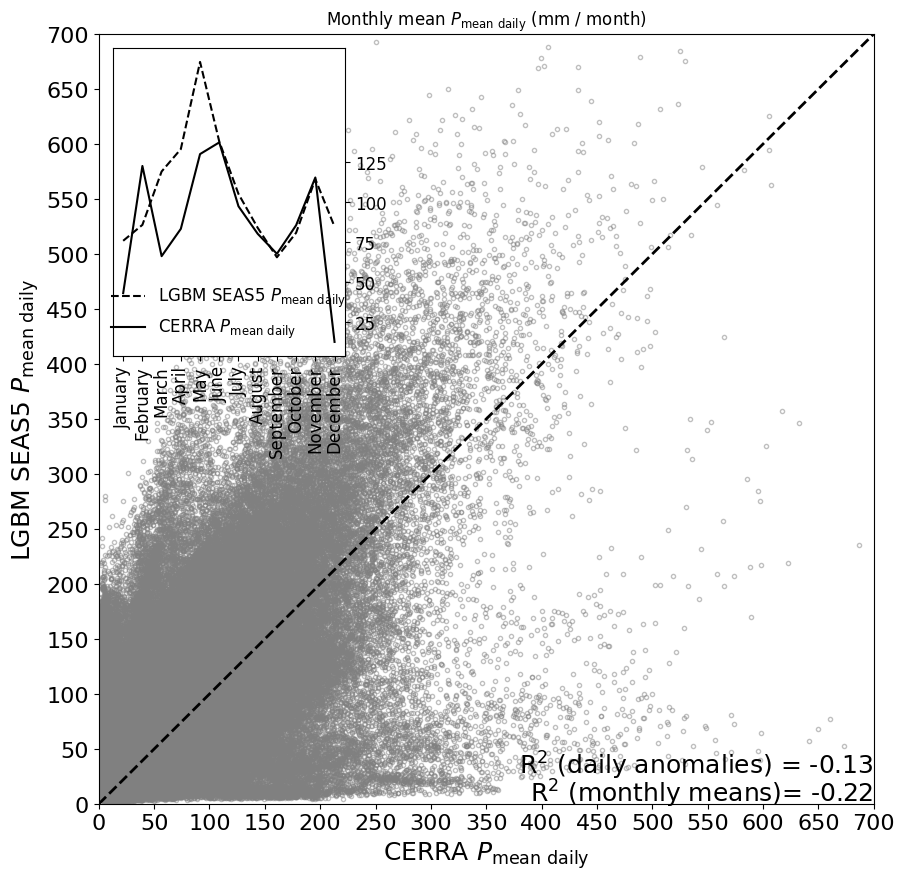

In [16]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot only a subset of data: otherwise plot is overloaded ...
# subset = np.random.choice(np.arange(0, len(y_pred_values)), size=int(1e3), replace=False)
# ax.plot(y_true_values[subset], y_pred_values[subset], 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot 1:1 mapping line
interval = np.arange(0, 750, 50)
ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 2, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 27.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)

# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel(TRUE, fontsize=18)
ax.set_ylabel(PRED, fontsize=18)
ax.set_title('Monthly mean {} (mm / month)'.format(str('$P_{\mathrm{mean \ daily}}$'), fontsize=20, pad=10));

# add axis for annual cycle
axins = inset_axes(ax, width="30%", height="40%", loc=2, borderpad=1)
axins.plot(y_pred_ac, ls='--', color='k', label=PRED)
axins.plot(y_true_ac, ls='-', color='k', label=TRUE)
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.set_yticks(np.arange(25, 150, 25))
axins.set_yticklabels(np.arange(25, 150, 25), fontsize=12)
axins.yaxis.tick_right()
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/sf_{}_r2.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Coefficient of determination: Spatially

In [17]:
# iterate over the grid points
r2 = np.ones((2, len(y_pred_m.y), len(y_pred_m.x)), dtype=np.float32) * np.nan
for i, _ in enumerate(y_pred_m.x):
    for j, _ in enumerate(y_pred_m.y):
        # get observed and predicted monthly precipitation for current grid point
        point_true = y_true_m.isel(x=i, y=j)
        point_pred = y_pred_m.isel(x=i, y=j)
        
        # remove missing values
        mask = ((~np.isnan(point_true)) & (~np.isnan(point_pred)))
        point_true = point_true[mask].values
        point_pred = point_pred[mask].values
        if point_true.size < 1:
            continue
        
        # get anomalies for current grid point
        point_anom_true = y_true_anom.isel(x=i, y=j)
        point_anom_pred = y_pred_anom.isel(x=i, y=j)
        
        # remove missing values
        mask_anom = ((~np.isnan(point_anom_true)) & (~np.isnan(point_anom_pred)))
        point_anom_true = point_anom_true[mask_anom].values
        point_anom_pred = point_anom_pred[mask_anom].values

        # compute coefficient of determination
        r2[0, j, i] = r2_score(point_true, point_pred)
        r2[1, j, i] = r2_score(point_anom_true, point_anom_pred)

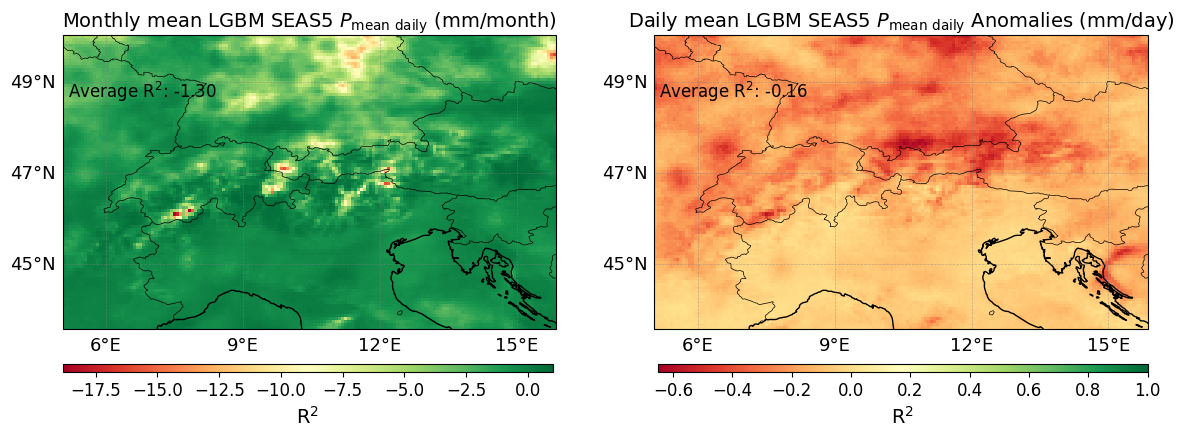

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.ticker as mticker

x_values = y_true.x.values
y_values = y_true.y.values
r22 = xr.DataArray(
    r2,
    dims=('number', 'y', 'x'),
    coords={'x': x_values, 'y': y_values}
)
r22.rio.set_crs("EPSG:4326", inplace=True)

# Plot each number separately
numbers = [0, 1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_axes = [None] * 2  # Create an empty list to store colorbar axes

for i, number in enumerate(numbers):
    ax = axes[i]
    
    # Select data for the current number
    ds_number = r22.sel(number=number)
    
    # Plot the data
    if i == 0:
        im = ds_number.plot(ax=ax, cmap='RdYlGn', vmin=ds_number.min().values, vmax=1, add_colorbar=False)
        cbar_axes[i] = fig.add_axes([0.125, 0.02, 0.35, 0.02])
        cbar = fig.colorbar(im, cax=cbar_axes[i], orientation='horizontal')
    elif i == 1:
        im = ds_number.plot(ax=ax, cmap='RdYlGn', vmin=ds_number.min().values, vmax=1, add_colorbar=False)
        cbar_axes[i] = fig.add_axes([0.55, 0.02, 0.35, 0.02])
        cbar = fig.colorbar(im, cax=cbar_axes[i], orientation='horizontal')
    
    # Add country borders
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='solid', edgecolor='black')
    
    # Add coastlines
    ax.coastlines()
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.bottom_labels = True
    gl.left_labels = True
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([6, 9, 12, 15])
    gl.ylocator = mticker.FixedLocator([45, 47, 49])
    gl.xlabel_style = {'size': 13}  # Adjust the font size as needed
    gl.ylabel_style = {'size': 13}

    # Remove x-axis and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove y-axis ticks and labels
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])

    # Remove y-axis ticks and labels
    ax.xaxis.set_ticks([])
    ax.xaxis.set_ticklabels([])
    
    # Set title
    if i == 0:
        ax.set_title('Monthly mean {} (mm/month)'.format(PRED), fontsize=14)
        ax.text(0.01, 0.85, 'Average R$^2$: {:.2f}'.format(np.nanmean(r2[0, :])), ha='left', va='top', transform=ax.transAxes, fontsize=12, color='black')

    elif i == 1:
        ax.set_title('Daily mean {} Anomalies (mm/day)'.format(PRED), fontsize=14)
        ax.text(0.01, 0.85, 'Average R$^2$: {:.2f}'.format(np.nanmean(r2[1, :])), ha='left', va='top', transform=ax.transAxes, fontsize=12, color='black')



# Customize colorbars
cbar_axes[0].set_xlabel('R$^2$', fontsize=14)
cbar_axes[1].set_xlabel('R$^2$', fontsize=14)
cbar_axes[0].xaxis.set_tick_params(labelsize=12)
cbar_axes[1].xaxis.set_tick_params(labelsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.2)  # Adjust spacing between subplots
plt.show()


# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/sf_{}_r2_spatial_pr.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias

Calculate yearly average bias over entire reference period:

In [19]:
# average bias of daily precipitation over reference period
y_pred_yearly_avg = y_pred_pr.groupby('time.year').mean(dim='time')
#y_refe_yearly_avg = y_refe.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')
bias_yearly_avg = ((y_pred_yearly_avg - y_true_yearly_avg) / y_true_yearly_avg) * 100
print('({}:{}) Yearly average relative bias: {:.2f}%'.format(TRUE, PRED, bias_yearly_avg.mean().item()))

(CERRA $P_{\mathrm{mean \ daily}}$:LGBM SEAS5 $P_{\mathrm{mean \ daily}}$) Yearly average relative bias: 69.88%


In [20]:
# mean absolute error over reference period
mae_avg = np.abs(y_pred_yearly_avg - y_true_yearly_avg)
print('({}:{}) Yearly average MAE: {:.2f} mm'.format(TRUE, PRED, mae_avg.mean().item()))

(CERRA $P_{\mathrm{mean \ daily}}$:LGBM SEAS5 $P_{\mathrm{mean \ daily}}$) Yearly average MAE: 1.26 mm


In [21]:
# root mean squared error over reference period
rmse_avg = np.sqrt(((y_pred_yearly_avg - y_true_yearly_avg) ** 2).mean())
print('({}:{}) Yearly average RMSE: {:.2f} mm / day'.format(TRUE, PRED, rmse_avg.item()))

(CERRA $P_{\mathrm{mean \ daily}}$:LGBM SEAS5 $P_{\mathrm{mean \ daily}}$) Yearly average RMSE: 1.56 mm / day


In [22]:
# Pearson's correlation coefficient over reference period
for year in y_pred_yearly_avg.year:
    y_p = y_pred_yearly_avg.sel(year=year).values        
    y_t = y_true_yearly_avg.sel(year=year).values
    r, _ = stats.pearsonr(y_p[~np.isnan(y_p)], y_t[~np.isnan(y_t)])
    print('({:0d}) Pearson correlation: {:.2f}'.format(year.item(), np.asarray(r).mean()))
r, _ = stats.pearsonr(y_pred_yearly_avg.values[~np.isnan(y_pred_yearly_avg.values)],
                      y_true_yearly_avg.values[~np.isnan(y_true_yearly_avg.values)])
print('Total: {:.2f}'.format(r))

(2016) Pearson correlation: 0.66
(2017) Pearson correlation: 0.58
Total: 0.67


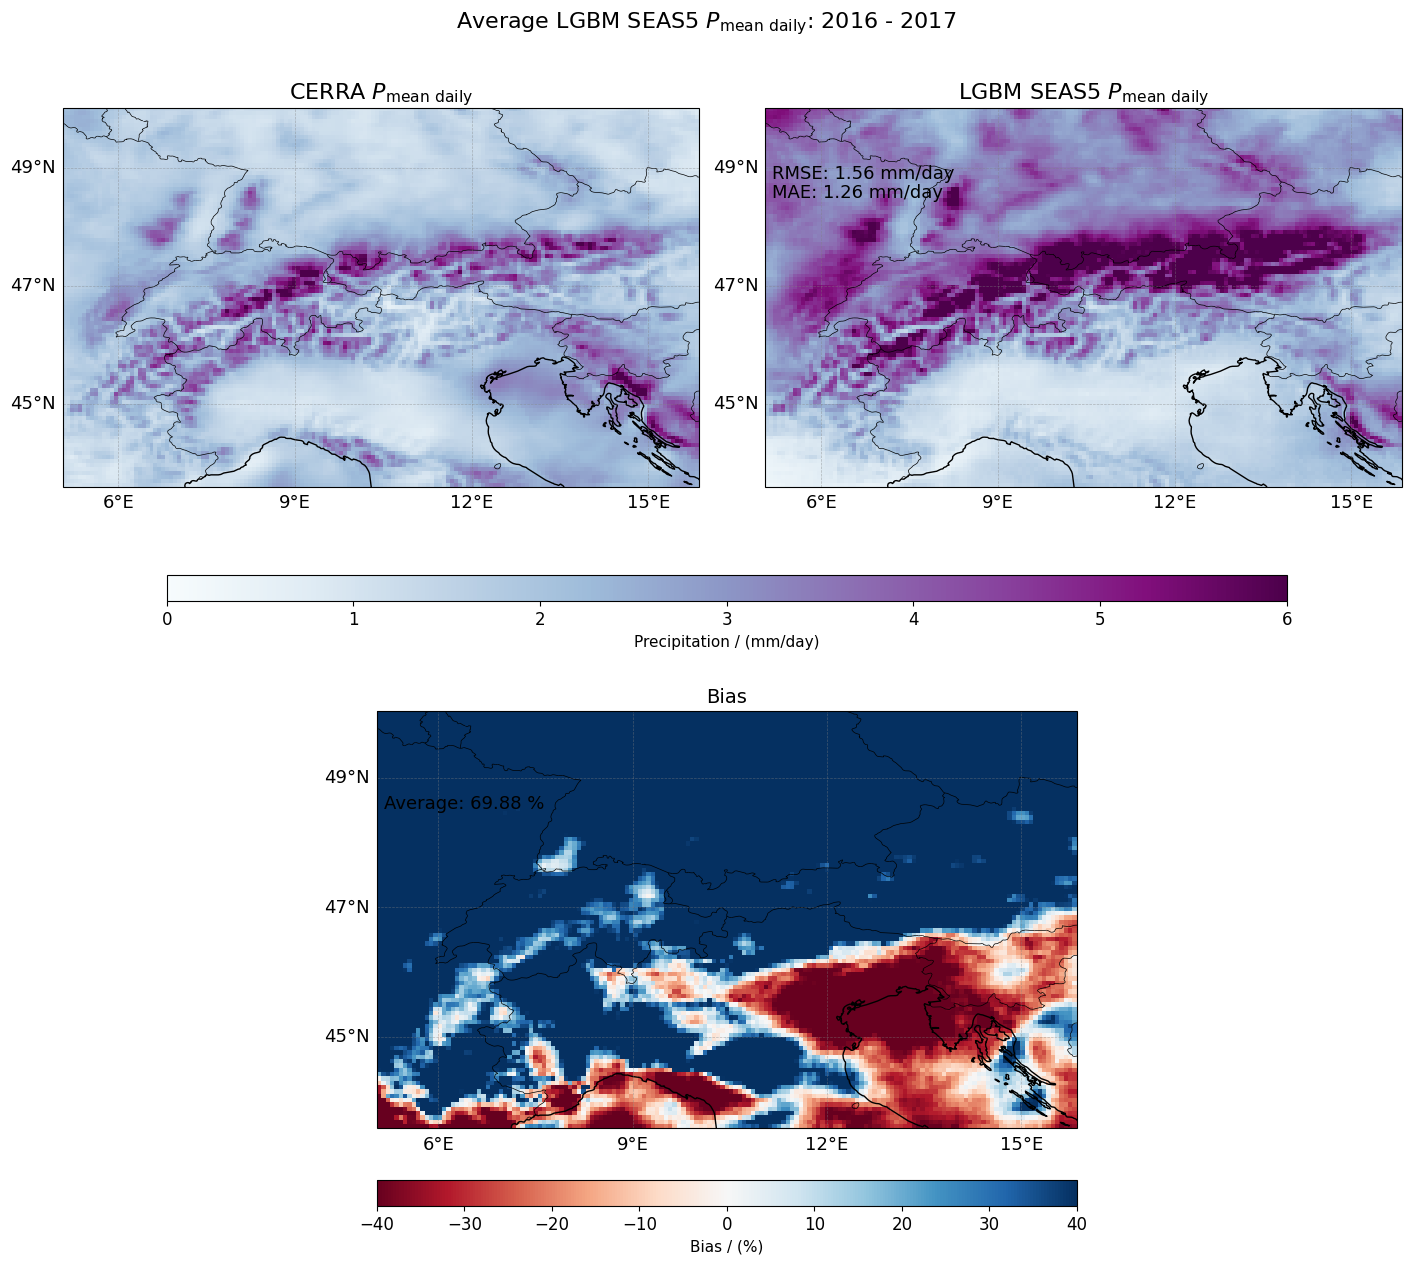

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.ticker as mticker

# Assuming you have your bias_snl xarray dataarray object
# Set the CRS to EPSG 4326
ds_true_mean = y_true_yearly_avg.mean(dim="year")
ds_pred_mean = y_pred_yearly_avg.mean(dim="year")
bias = bias_yearly_avg.mean(dim="year")
ds_true_mean.rio.set_crs("EPSG:4326", inplace=True)
ds_pred_mean.rio.set_crs("EPSG:4326", inplace=True)
bias.rio.set_crs("EPSG:4326", inplace=True)
#ds_true_mean = ds_true_mean.drop_vars("heightAboveGround")

# Add a new dimension named 'number' with values [0, 1, 2] to each data array
three = xr.concat([ds_true_mean, ds_pred_mean, bias], dim='number')

# Plot each number separately
numbers = [0, 1, 2]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 13), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

for i, number in enumerate(numbers):
    if i == 2:
        ax = axes[1, 0]  # Bias plot centered in the second row
        ax.set_position([0.265, 0.07, 0.5, 0.4])  # Adjust position to center
    else:
        ax = axes[i // 2, i % 2]  # Adjust row and column index
    
    
    # Select data for the current number
    ds_number = three.sel(number=number)
    
    # Plot the data
    if i == 2:
        im = ds_number.plot(ax=ax, cmap='RdBu', vmin=-40, vmax=40, add_colorbar=False)
    else:
        img = ds_number.plot(ax=ax, cmap='BuPu', vmin=0, vmax=6, add_colorbar=False)
    
    # Add country borders
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='solid', edgecolor='black')
    
    # Add coastlines
    ax.coastlines()
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.bottom_labels = True
    gl.left_labels = True
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([6, 9, 12, 15])
    gl.ylocator = mticker.FixedLocator([45, 47, 49])
    gl.xlabel_style = {'size': 13}  # Adjust the font size as needed
    gl.ylabel_style = {'size': 13}

    # Remove x-axis and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove y-axis ticks and labels
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])

    # Remove x-axis ticks and labels
    ax.xaxis.set_ticks([])
    ax.xaxis.set_ticklabels([])
    
    # Set title
    if i == 0:
        ax.set_title(TRUE, fontsize=16)
    elif i == 1:
        ax.set_title(PRED, fontsize=16)
        ax.text(0.01, 0.85, "RMSE: {:.2f} mm/day".format(rmse_avg.item()), ha='left', va='top', transform=ax.transAxes, fontsize=13, color='black')
        ax.text(0.01, 0.8, "MAE: {:.2f} mm/day".format(mae_avg.mean().item()), ha='left', va='top', transform=ax.transAxes, fontsize=13, color='black')
    elif i == 2:
        ax.set_title('Bias', fontsize=14)
        ax.text(0.01, 0.8, "Average: {:.2f} %".format(bias_yearly_avg.mean().item()), ha='left', va='top', transform=ax.transAxes, fontsize=13, color='black')

fig.suptitle('Average {}: {} - {}'.format(PRED, start_year, end_year), fontsize=16, y=0.97);

# Create a common colorbar for bias
cbar_ax_bias = fig.add_axes([0.115, 0.515, 0.8, 0.02])  # Adjust height to fit properly
cbar_bias = fig.colorbar(img, cax=cbar_ax_bias, orientation='horizontal')
cbar_bias.set_label('Precipitation / (mm/day)', fontsize=11)
cbar_bias.ax.tick_params(labelsize=12)
# Hide the empty subplot
fig.delaxes(axes[1, 1])

# Add a separate colorbar for the second row plot
cbar_ax_second_row = fig.add_axes([0.265, 0.05, 0.5, 0.02])  # Adjust height to fit properly
cbar_second_row = fig.colorbar(im, cax=cbar_ax_second_row, orientation='horizontal')
cbar_second_row.set_label('Bias / (%)', fontsize=11)  # Set your label
cbar_second_row.ax.tick_params(labelsize=12)
#cbar_second_row.set_ticks([your_ticks])  # Set your ticks
#cbar_second_row.set_ticklabels([your_tick_labels])  # Set your tick labels

plt.show()


# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/sf_{}_bias_pr.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

In [24]:
bias.median().values

array(67.91119076)

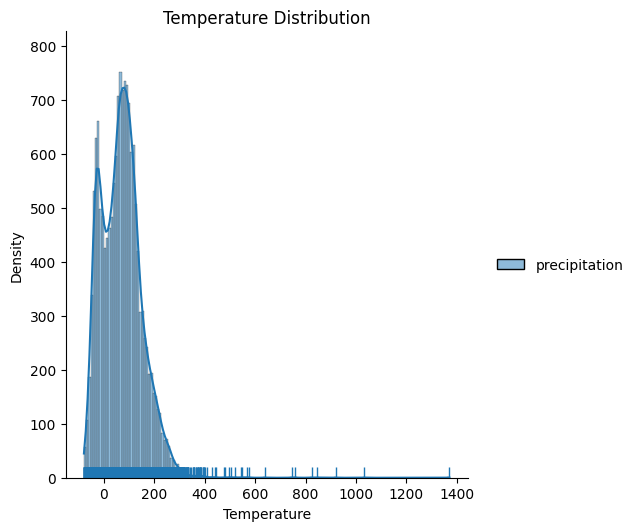

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr

# Load your xarray dataset
# For demonstration, let's assume your dataset is loaded and assigned to the variable 'ds'
# For this example, let's assume 'temperature' is a variable in your dataset
# Replace 'temperature' with the name of the variable you want to plot

# Example:
# ds = xr.open_dataset('your_dataset.nc')

# Assuming your dataset has a variable named 'temperature'


# Convert the xarray DataArray to a pandas DataFrame
tp_df = bias.to_dataframe()

# Plot the distribution using seaborn
sns.displot(tp_df, kde=True, rug=True)

# Add labels and title
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.title('Temperature Distribution')

plt.show()


### Seasonal bias

Calculate seasonal bias:

In [26]:
# group data by season: (DJF, MAM, JJA, SON)
y_true_snl = y_true.groupby('time.season').mean(dim='time')
y_pred_snl = y_pred_pr.groupby('time.season').mean(dim='time')
bias_snl = ((y_pred_snl - y_true_snl) / y_true_snl) * 100

In [27]:
# print average bias per season: Insitu:CERRA
for season in bias_snl.season:
    print('({}:{}) Average bias for season {}: {:.1f}%'.format(TRUE, PRED, season.values.item(), bias_snl.sel(season=season).mean().item()))

(CERRA $P_{\mathrm{mean \ daily}}$:LGBM SEAS5 $P_{\mathrm{mean \ daily}}$) Average bias for season DJF: 58.8%
(CERRA $P_{\mathrm{mean \ daily}}$:LGBM SEAS5 $P_{\mathrm{mean \ daily}}$) Average bias for season JJA: -4.2%
(CERRA $P_{\mathrm{mean \ daily}}$:LGBM SEAS5 $P_{\mathrm{mean \ daily}}$) Average bias for season MAM: 65.3%
(CERRA $P_{\mathrm{mean \ daily}}$:LGBM SEAS5 $P_{\mathrm{mean \ daily}}$) Average bias for season SON: 12.4%


Plot seasonal differences, taken from the [xarray documentation](xarray.pydata.org/en/stable/examples/monthly-means.html).

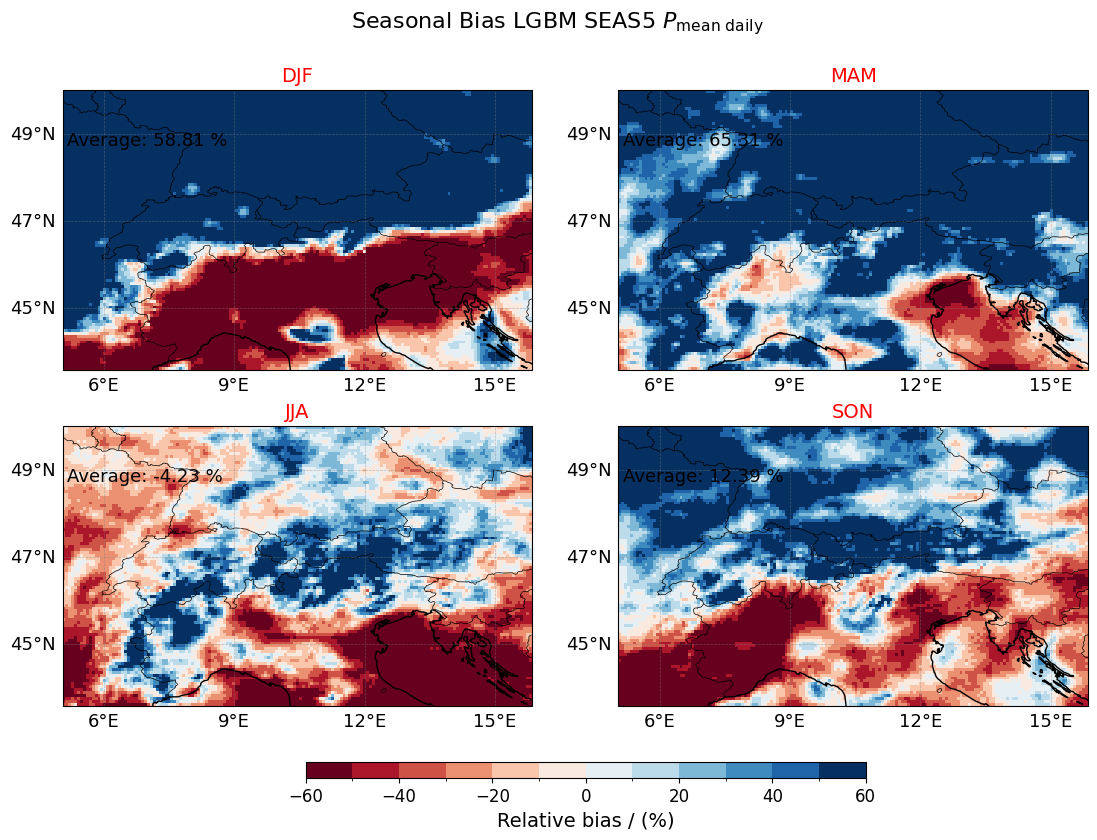

In [28]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm


# Assuming you have your bias_snl xarray dataarray object
# Set the CRS to EPSG 4326
bias_snl.rio.set_crs("EPSG:4326", inplace=True)

# Plot each season separately
seasons = ['DJF', 'MAM', 'JJA', 'SON']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree()})

for i, season in enumerate(seasons):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Select data for the current season
    ds_season = bias_snl.sel(season=season)
    
    # Plot the data with a custom colormap and normalizing the color bar
    levels = np.linspace(-60, 60, 13)  # 5% bins from -40 to 40
    norm = BoundaryNorm(levels, ncolors=256)
    im = ds_season.plot(ax=ax, cmap='RdBu', norm=norm, add_colorbar=False)
    
    # Add country borders
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='solid', edgecolor='black')
    
    # Add coastlines
    ax.coastlines()
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.bottom_labels = True
    gl.left_labels = True
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([6, 9, 12, 15])
    gl.ylocator = mticker.FixedLocator([45, 47, 49])
    gl.xlabel_style = {'size': 13}  # Adjust the font size as needed
    gl.ylabel_style = {'size': 13}



    # Remove x-axis and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove y-axis ticks and labels
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])

    # Remove y-axis ticks and labels
    ax.xaxis.set_ticks([])
    ax.xaxis.set_ticklabels([])
    # Set title
    ax.set_title('{}'.format(season), fontsize=14, color="red")
    ax.text(0.01, 0.85, 'Average: {:.2f} %'.format(ds_season.mean()), ha='left', va='top', transform=ax.transAxes, fontsize=13, color='black')

fig.suptitle('Seasonal Bias {}'.format(PRED), fontsize=16);

# Add colorbar at the bottom
cbar_ax_predictand = fig.add_axes([0.32, 0.02, 0.4, 0.02])
cbar_predictand = fig.colorbar(im, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='Relative bias / (%)', fontsize=14)
cbar_predictand.ax.tick_params(labelsize=12)

plt.subplots_adjust(wspace=0.05, hspace=0.2)  # Adjust spacing between subplots
plt.show()


# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/pr_{}_bias_seasonal.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias of extreme values

In [29]:
# extreme quantile of interest
quantile = 0.98

In [30]:
# calculate extreme quantile for each year
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    y_pred_ex = y_pred_pr.groupby('time.year').quantile(quantile, dim='time')
    y_true_ex = y_true.groupby('time.year').quantile(quantile, dim='time')

In [31]:
# calculate bias in extreme quantile for each year
bias_ex = ((y_pred_ex - y_true_ex) / y_true_ex) * 100

In [32]:
# bias of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average bias for P{:.0f}: {:.1f}%'.format(TRUE, PRED, quantile * 100, bias_ex.mean().item()))

(CERRA $P_{\mathrm{mean \ daily}}$:LGBM SEAS5 $P_{\mathrm{mean \ daily}}$) Yearly average bias for P98: -33.1%


In [33]:
# mean absolute error in extreme quantile
mae_ex = np.abs(y_pred_ex - y_true_ex).mean()

In [34]:
# mae of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average MAE for P{:.0f}: {:.1f} mm / day'.format(TRUE, PRED, quantile * 100, mae_ex.item()))

(CERRA $P_{\mathrm{mean \ daily}}$:LGBM SEAS5 $P_{\mathrm{mean \ daily}}$) Yearly average MAE for P98: 8.3 mm / day


In [35]:
# root mean squared error in extreme quantile
rmse_ex = np.sqrt(((y_pred_ex - y_true_ex) ** 2).mean())

In [36]:
# rmse of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average RMSE for P{:.0f}: {:.1f} mm / day'.format(TRUE, PRED, quantile * 100, rmse_ex.item()))

(CERRA $P_{\mathrm{mean \ daily}}$:LGBM SEAS5 $P_{\mathrm{mean \ daily}}$) Yearly average RMSE for P98: 11.0 mm / day


In [37]:
bias.max().values

array(1370.46596311)

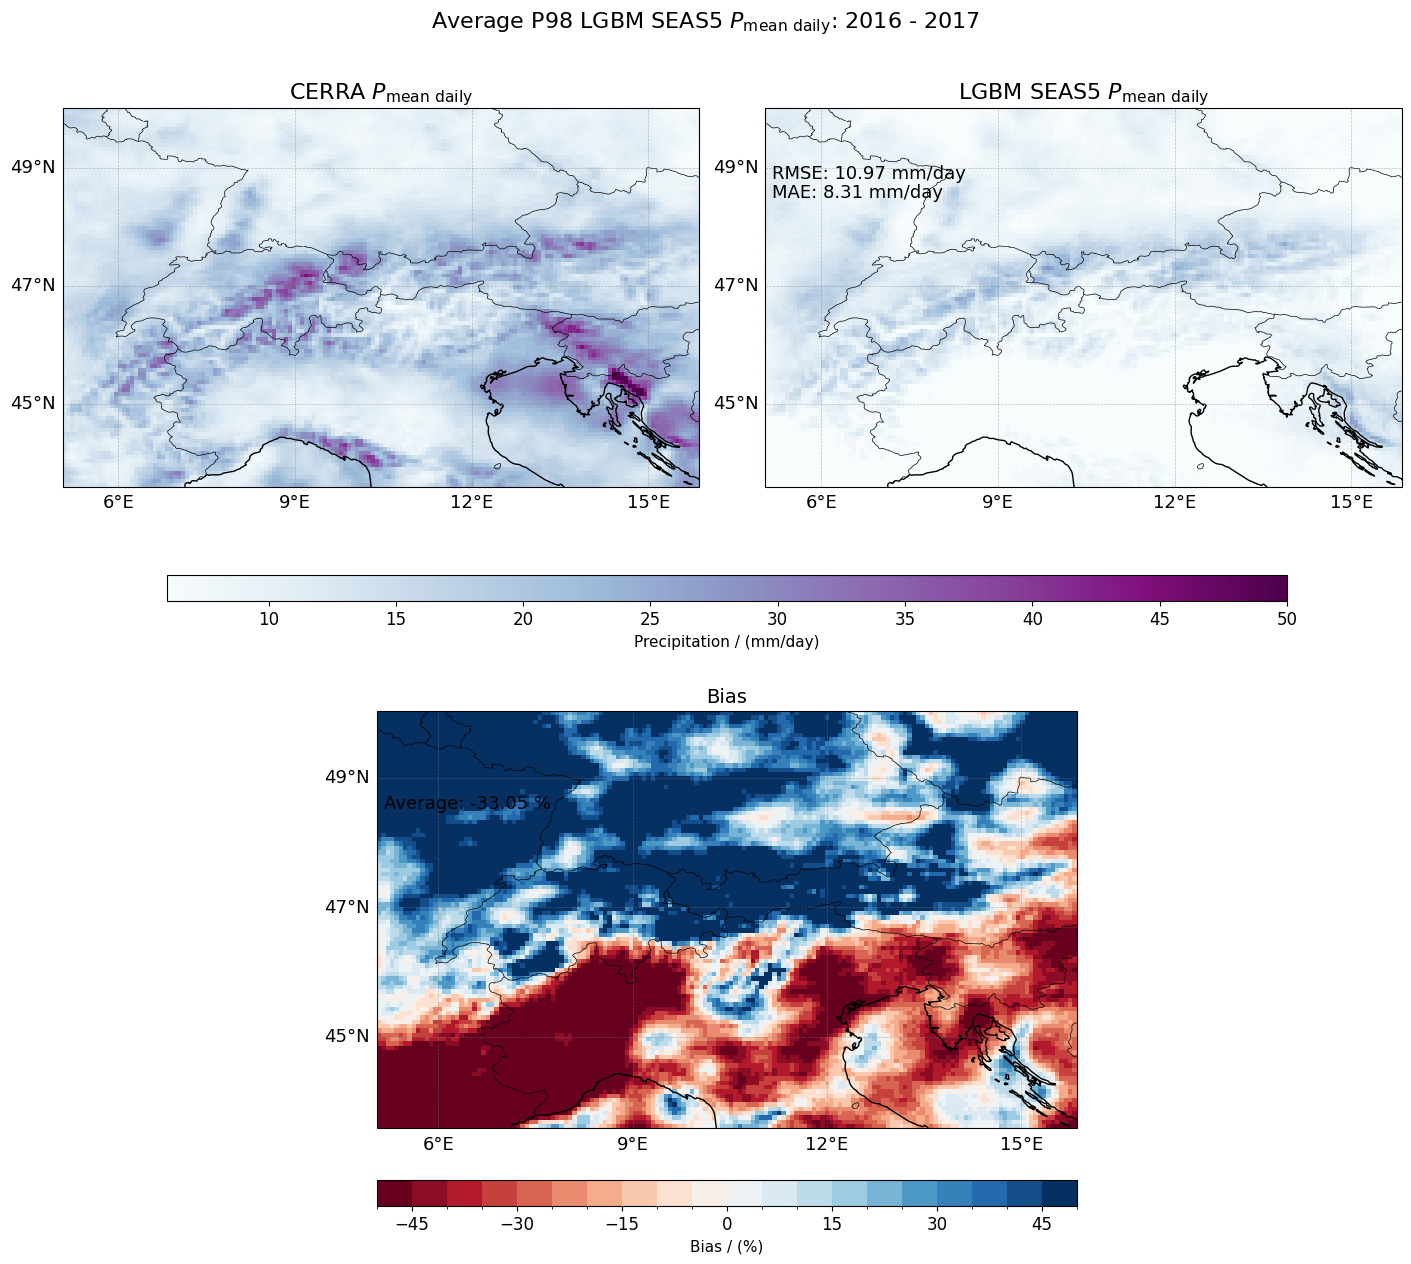

In [38]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.ticker as mticker

# Assuming you have your bias_snl xarray dataarray object
# Set the CRS to EPSG 4326
ds_true_ex = y_true_ex.mean(dim="year")
ds_pred_ex = y_pred_ex.mean(dim="year")
ds_true_ex.rio.set_crs("EPSG:4326", inplace=True)
ds_pred_ex.rio.set_crs("EPSG:4326", inplace=True)
#ds_true_mean = ds_true_mean.drop_vars("heightAboveGround")
bias = bias_ex.mean(dim="year")
bias.rio.set_crs("EPSG:4326", inplace=True)

# Add a new dimension named 'number' with values [0, 1, 2] to each data array
three = xr.concat([ds_true_ex, ds_pred_ex, bias], dim='number')

# Plot each number separately
numbers = [0, 1, 2]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 13), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

for i, number in enumerate(numbers):
    if i == 2:
        ax = axes[1, 0]  # Bias plot centered in the second row
        ax.set_position([0.265, 0.07, 0.5, 0.4])  # Adjust position to center
    else:
        ax = axes[i // 2, i % 2]  # Adjust row and column index
    
    
    # Select data for the current number
    ds_number = three.sel(number=number)
    
    # Plot the data
    if i == 2:
        # Plot the data with a custom colormap and normalizing the color bar
        levels = np.linspace(-50, 50, 21)  # 5% bins from -40 to 40
        norm = BoundaryNorm(levels, ncolors=256)
        im = ds_season.plot(ax=ax, cmap='RdBu', norm=norm, add_colorbar=False)
    else:
        img = ds_number.plot(ax=ax, cmap='BuPu', vmin=6, vmax=50, add_colorbar=False)
    
    # Add country borders
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='solid', edgecolor='black')
    
    # Add coastlines
    ax.coastlines()
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.bottom_labels = True
    gl.left_labels = True
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([6, 9, 12, 15])
    gl.ylocator = mticker.FixedLocator([45, 47, 49])
    gl.xlabel_style = {'size': 13}  # Adjust the font size as needed
    gl.ylabel_style = {'size': 13}

    # Remove x-axis and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove y-axis ticks and labels
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])

    # Remove x-axis ticks and labels
    ax.xaxis.set_ticks([])
    ax.xaxis.set_ticklabels([])
    
    # Set title
    if i == 0:
        ax.set_title(TRUE, fontsize=16)
    elif i == 1:
        ax.set_title(PRED, fontsize=16)
        ax.text(0.01, 0.85, "RMSE: {:.2f} mm/day".format(rmse_ex.item()), ha='left', va='top', transform=ax.transAxes, fontsize=13, color='black')
        ax.text(0.01, 0.8, "MAE: {:.2f} mm/day".format(mae_ex.mean().item()), ha='left', va='top', transform=ax.transAxes, fontsize=13, color='black')
    elif i == 2:
        ax.set_title('Bias', fontsize=14)
        ax.text(0.01, 0.8, "Average: {:.2f} %".format(bias_ex.mean().item()), ha='left', va='top', transform=ax.transAxes, fontsize=13, color='black')

fig.suptitle('Average P98 {}: {} - {}'.format(PRED, start_year, end_year), fontsize=16, y=0.97);

# Create a common colorbar for bias
cbar_ax_bias = fig.add_axes([0.115, 0.515, 0.8, 0.02])  # Adjust height to fit properly
cbar_bias = fig.colorbar(img, cax=cbar_ax_bias, orientation='horizontal')
cbar_bias.set_label('Precipitation / (mm/day)', fontsize=11)
cbar_bias.ax.tick_params(labelsize=12)
# Hide the empty subplot
fig.delaxes(axes[1, 1])

# Add a separate colorbar for the second row plot
cbar_ax_second_row = fig.add_axes([0.265, 0.05, 0.5, 0.02])  # Adjust height to fit properly
cbar_second_row = fig.colorbar(im, cax=cbar_ax_second_row, orientation='horizontal')
cbar_second_row.set_label('Bias / (%)', fontsize=11)  # Set your label
cbar_second_row.ax.tick_params(labelsize=12)
#cbar_second_row.set_ticks([your_ticks])  # Set your ticks
#cbar_second_row.set_ticklabels([your_tick_labels])  # Set your tick labels

plt.show()


# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/sf_{}_bias_p{:.0f}.png'.format(PREDICTAND, quantile * 100), dpi=300, bbox_inches='tight')

### Bias of extremes: winter vs. summer

In [39]:
# group data by season and compute extreme percentile
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    y_true_ex_snl = y_true.groupby('time.season').quantile(quantile, dim='time')
    y_pred_ex_snl = y_pred_pr.groupby('time.season').quantile(quantile, dim='time')

In [40]:
# compute relative bias in seasonal extremes
bias_ex_snl = ((y_pred_ex_snl - y_true_ex_snl) / y_true_ex_snl) * 100

In [41]:
# print average bias in extreme per season: Insitu:CERRA
for season in bias_ex_snl.season:
    print('({}:{}) Average bias of P{:.0f} for season {}: {:.1f}%'.format(TRUE, PRED, quantile * 100, season.values.item(), bias_ex_snl.sel(season=season).mean().item()))

(CERRA $P_{\mathrm{mean \ daily}}$:LGBM SEAS5 $P_{\mathrm{mean \ daily}}$) Average bias of P98 for season DJF: -44.0%
(CERRA $P_{\mathrm{mean \ daily}}$:LGBM SEAS5 $P_{\mathrm{mean \ daily}}$) Average bias of P98 for season JJA: -62.2%
(CERRA $P_{\mathrm{mean \ daily}}$:LGBM SEAS5 $P_{\mathrm{mean \ daily}}$) Average bias of P98 for season MAM: -44.0%
(CERRA $P_{\mathrm{mean \ daily}}$:LGBM SEAS5 $P_{\mathrm{mean \ daily}}$) Average bias of P98 for season SON: -52.4%


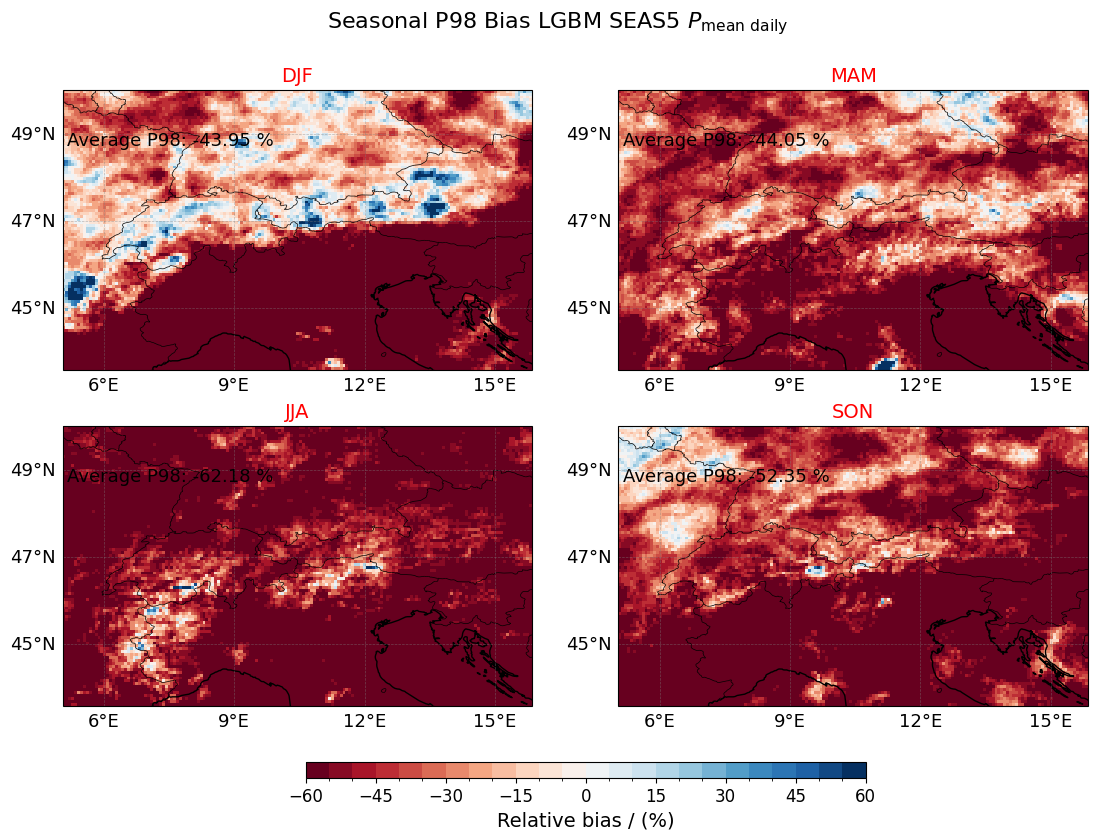

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.ticker as mticker


# Assuming you have your bias_snl xarray dataarray object
# Set the CRS to EPSG 4326
bias_ex_snl.rio.set_crs("EPSG:4326", inplace=True)

# Plot each season separately
seasons = ['DJF', 'MAM', 'JJA', 'SON']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree()})

for i, season in enumerate(seasons):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Select data for the current season
    ds_season = bias_ex_snl.sel(season=season)
    
    # Plot the data
    levels = np.linspace(-60, 60, 25)  # 10% bins from -100 to 100
    norm = BoundaryNorm(levels, ncolors=256)
    im = ds_season.plot(ax=ax, cmap='RdBu', norm=norm, add_colorbar=False)
    
    # Add country borders
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='solid', edgecolor='black')
    
    # Add coastlines
    ax.coastlines()
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.bottom_labels = True
    gl.left_labels = True
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([6, 9, 12, 15])
    gl.ylocator = mticker.FixedLocator([45, 47, 49])
    gl.xlabel_style = {'size': 13}  # Adjust the font size as needed
    gl.ylabel_style = {'size': 13}



    # Remove x-axis and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove y-axis ticks and labels
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])

    # Remove y-axis ticks and labels
    ax.xaxis.set_ticks([])
    ax.xaxis.set_ticklabels([])
    # Set title
    ax.set_title('{}'.format(season), fontsize=14, color="red")
    ax.text(0.01, 0.85, 'Average P98: {:.2f} %'.format(ds_season.mean()), ha='left', va='top', transform=ax.transAxes, fontsize=13, color='black')

fig.suptitle('Seasonal P98 Bias {}'.format(PRED), fontsize=16);

# Add colorbar at the bottom
cbar_ax_predictand = fig.add_axes([0.32, 0.02, 0.4, 0.02])
cbar_predictand = fig.colorbar(im, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='Relative bias / (%)', fontsize=14)
cbar_predictand.ax.tick_params(labelsize=12)

plt.subplots_adjust(wspace=0.05, hspace=0.2)  # Adjust spacing between subplots
plt.show()

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/sf_{}_bias_p{:.0f}_seasonal.png'.format(PREDICTAND, quantile * 100), dpi=300, bbox_inches='tight')

In [43]:
for i in bias_ex_snl.season:
    ds_season = bias_ex_snl.sel(season=i)
    print(ds_season.min().values, ds_season.max().values)

-97.92977441012602 141.7314814134617
-97.13756308628366 87.68278972379275
-89.58220619205125 288.7278847809621
-94.7636403480225 57.07885313342849


### Frequency of wet days

In [44]:
# minimum precipitation (mm / day) defining a wet day
WET_DAY_THRESHOLD = 1
WET_DAY_THRESHOLD = float(WET_DAY_THRESHOLD)

In [45]:
# true and predicted frequency of wet days
mask = (~np.isnan(y_true)) & (~np.isnan(y_pred_pr))
wet_days_true = (y_true >= WET_DAY_THRESHOLD).where(mask, other=np.nan).astype(np.float32)
wet_days_pred = (y_pred_pr >= WET_DAY_THRESHOLD).where(mask, other=np.nan).astype(np.float32)

In [46]:
# number of wet days in reference period: annual
n_wet_days_true = wet_days_true.sum(dim='time', skipna=False)
n_wet_days_pred = wet_days_pred.sum(dim='time', skipna=False)

In [47]:
# frequency of wet days in reference period: annual
f_wet_days_true = (n_wet_days_true / len(wet_days_true.time)) * 100
f_wet_days_pred = (n_wet_days_pred / len(wet_days_pred.time)) * 100

In [48]:
# frequency of wet days in reference period: seasonal
f_wet_days_true_snl = wet_days_true.groupby('time.season').mean(dim='time', skipna=False)
f_wet_days_pred_snl = wet_days_pred.groupby('time.season').mean(dim='time', skipna=False)

In [49]:
# relative bias of frequency of wet vs. dry days: annual
bias_wet = ((f_wet_days_pred - f_wet_days_true) / f_wet_days_true) * 100

# relative bias of frequency of wet vs. dry days: seasonal
bias_wet_snl = ((f_wet_days_pred_snl - f_wet_days_true_snl) / f_wet_days_true_snl) * 100

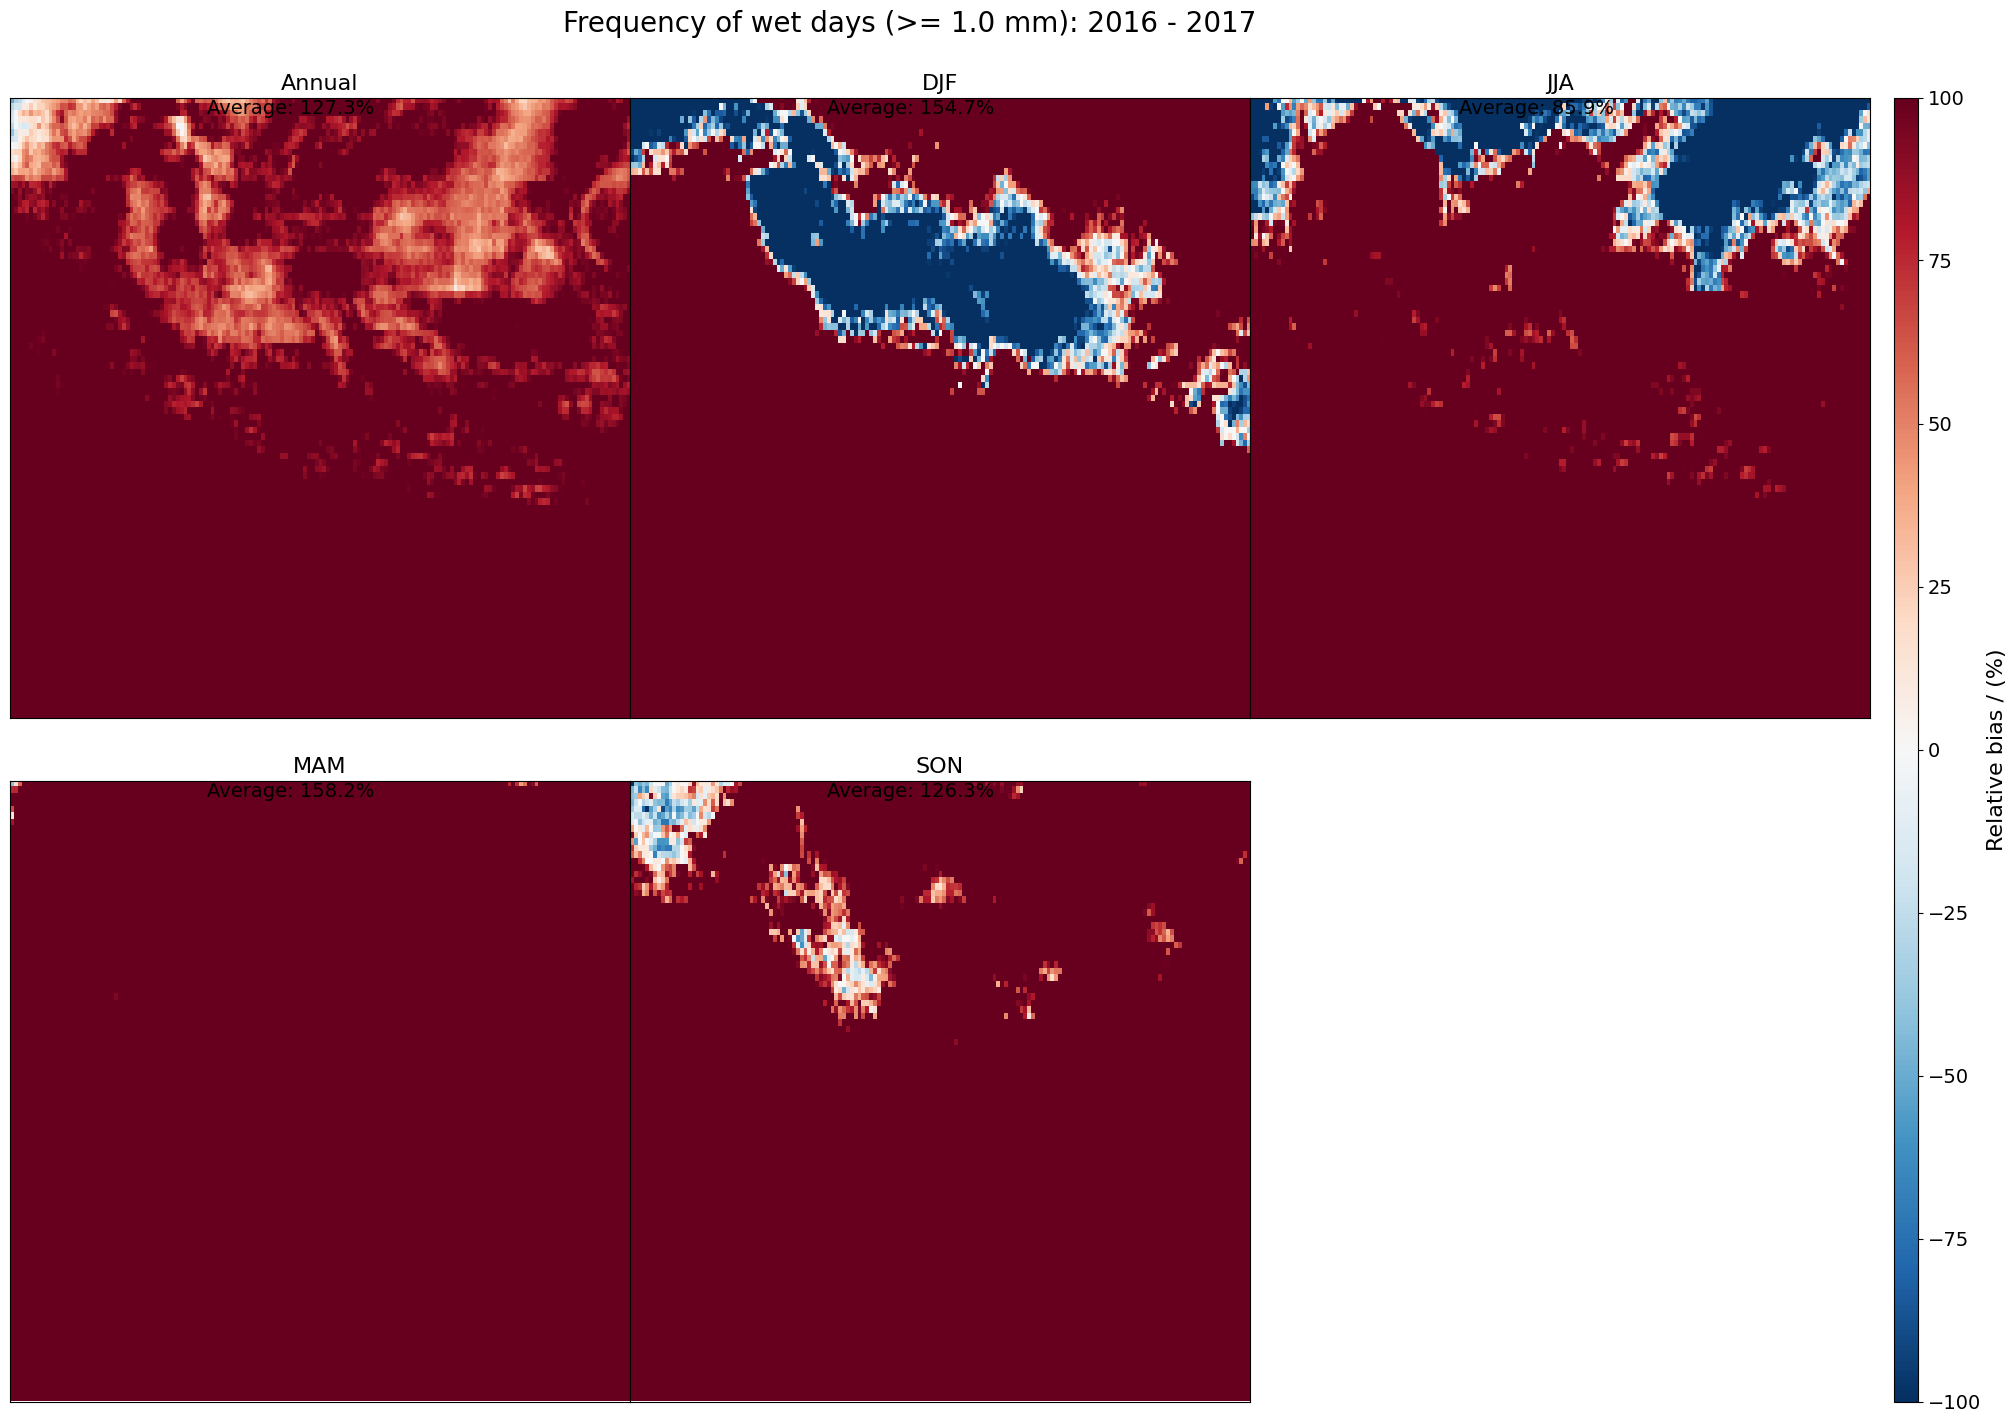

In [50]:
# plot average of observation, prediction, and bias
fig, axes = plt.subplots(2, 3, figsize=(24, 16), sharex=True, sharey=True)
axes = axes.flatten()

# plot annual average bias of extreme
ds = bias_wet
im = axes[0].imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-100, vmax=100)
axes[0].set_title('Annual', fontsize=16);
axes[0].text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')

# plot seasonal average bias of extreme
for ax, season in zip(axes[1:], bias_wet_snl.season):
    ds = bias_wet_snl.sel(season=season)
    ax.imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-40, vmax=40)
    ax.set_title(season.item(), fontsize=16);
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
# turn off last axis
axes[-1].set_visible(False)

# adjust figure
fig.suptitle('Frequency of wet days (>= {:.1f} mm): {} - {}'.format(WET_DAY_THRESHOLD, start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0.1, wspace=0, top=0.925)

# add colorbar
cbar_ax_predictand = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                                   0.01, axes[0].get_position().y1 - axes[-1].get_position().y0])
cbar_predictand = fig.colorbar(im, cax=cbar_ax_predictand)
cbar_predictand.set_label(label='Relative bias / (%)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/sf_{}_bias_wet_day.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Mean wet day precipitation

In [51]:
# calculate mean wet day precipitation
dii_true = (y_true * wet_days_true).sum(dim='time', skipna=False) / n_wet_days_true
dii_pred = (y_pred_pr * wet_days_pred).sum(dim='time', skipna=False) / n_wet_days_pred

In [52]:
# calculate relative bias of mean wet day precipitation
bias_dii = ((dii_pred - dii_true) / dii_true) * 100

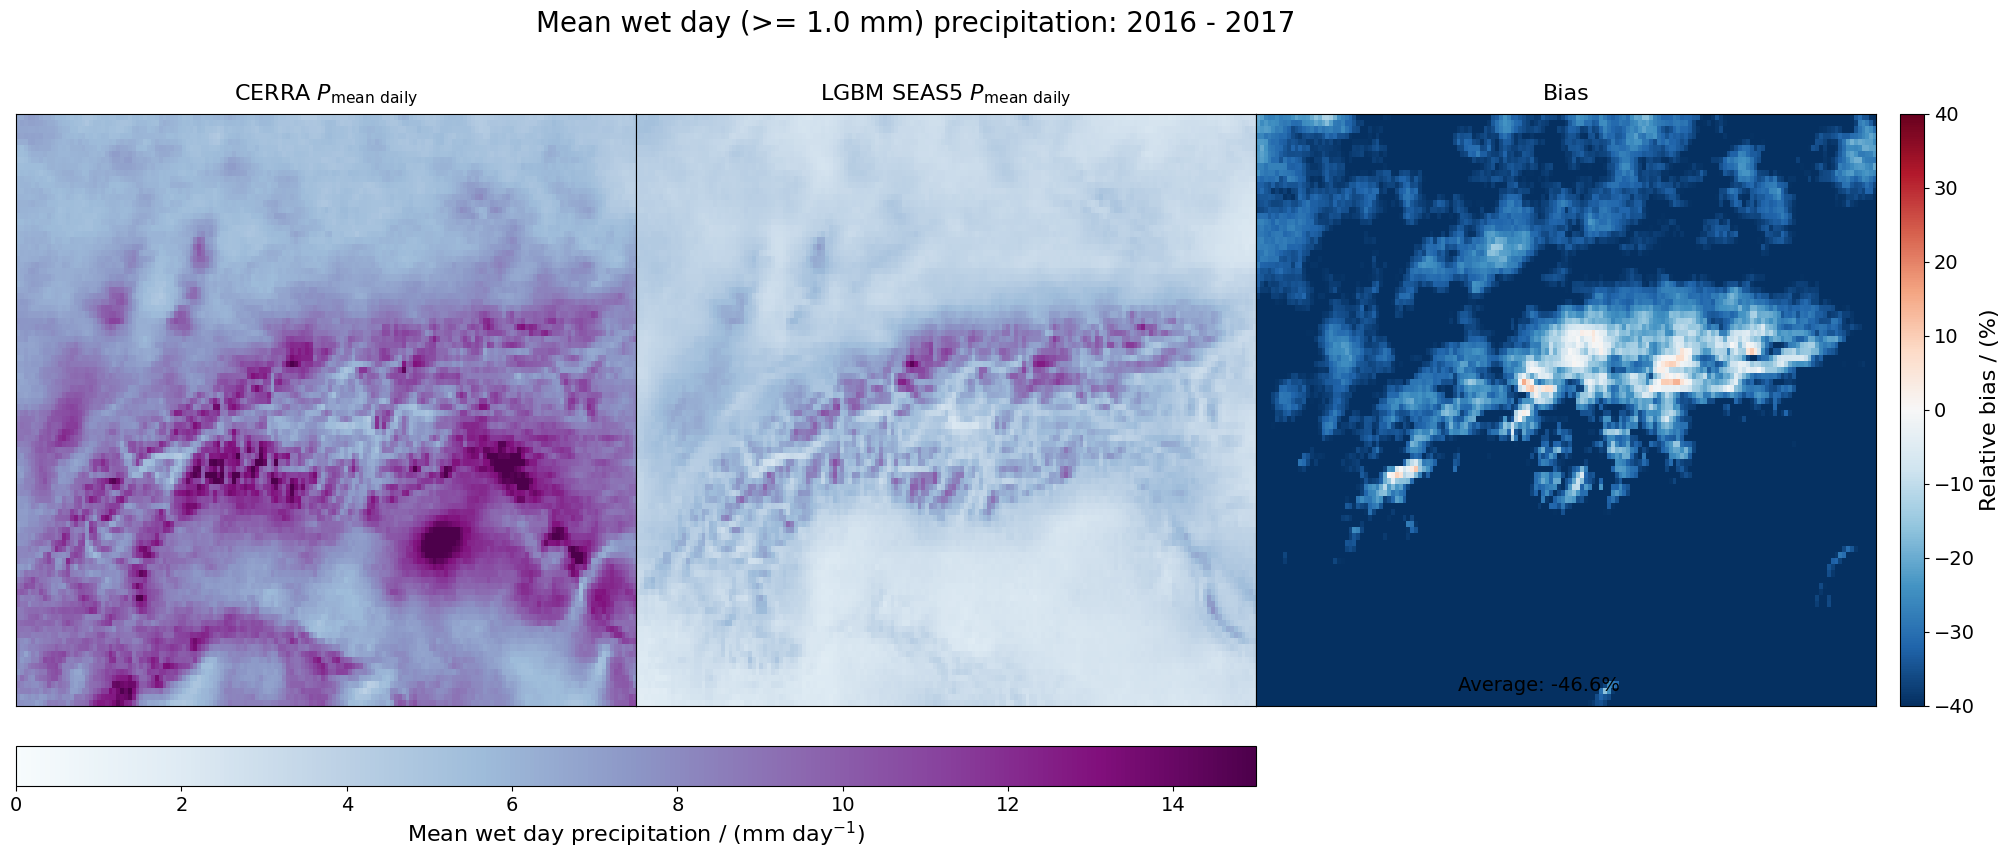

In [53]:
# plot average of observation, prediction, and bias
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
for ds, ax in zip([dii_true, dii_pred, bias_dii], axes):
    if ds is bias_dii:
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-40, vmax=40)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.values, origin='upper', cmap='BuPu', vmin=0, vmax=15)
        
# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Mean wet day (>= {:.1f} mm) precipitation: {} - {}'.format(WET_DAY_THRESHOLD, start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                             0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar_bias = fig.colorbar(im2, cax=cbar_ax_bias)
cbar_bias.set_label(label='Relative bias / (%)', fontsize=16)
cbar_bias.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='Mean wet day precipitation / (mm day$^{-1}$)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/sf_{}_bias_wdp.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

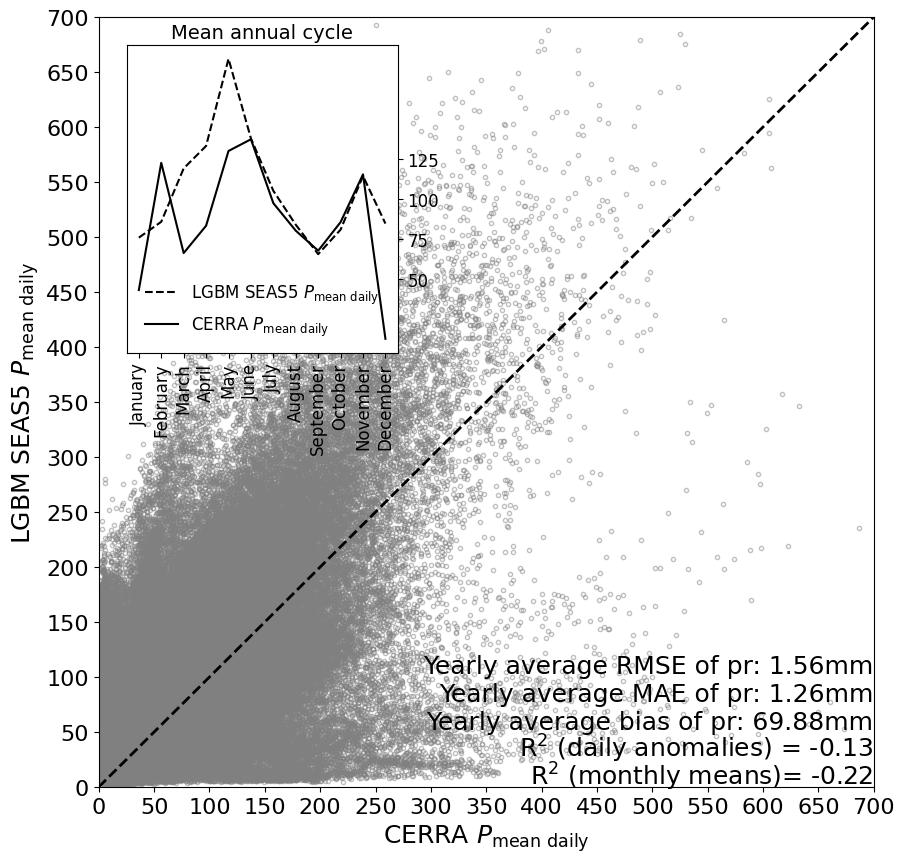

In [54]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot only a subset of data: otherwise plot is overloaded ...
# subset = np.random.choice(np.arange(0, len(y_pred_values)), size=int(1e3), replace=False)
# ax.plot(y_true_values[subset], y_pred_values[subset], 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot 1:1 mapping line
interval = np.arange(0, 750, 50)
ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 2, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 27.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 53, s='Yearly average bias of {}: {:.2f}mm'.format(PREDICTAND, bias_yearly_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 78.5, s='Yearly average MAE of {}: {:.2f}mm'.format(PREDICTAND, mae_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 104, s='Yearly average RMSE of {}: {:.2f}mm'.format(PREDICTAND, rmse_avg.mean().item()), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel(TRUE, fontsize=18)
ax.set_ylabel(PRED, fontsize=18)
#ax.set_title('Monthly mean {} (mm / month)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="35%", height="40%", loc=2, borderpad=2)
axins.plot(y_pred_ac, ls='--', color='k', label=PRED)
axins.plot(y_true_ac, ls='-', color='k', label=TRUE)
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.set_yticks(np.arange(50, 150, 25))
axins.set_yticklabels(np.arange(50, 150, 25), fontsize=12)
axins.yaxis.tick_right()
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/sf_{}_r2.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')